<center><h1>Time series analysis</h1></center>
<center><h2>Tutorial 4: ARIMA</h2></center>
<br>

This tutorial we add the ARIMA model to our analysis of the Australian inflation data from a previous tutorial. 

<a class="buttom" href=">#Data:-Australian-CPI-Inflation">Data: Australian CPI inflation</a><br>
<a class="buttom" href="#ARIMA-model-identification">ARIMA model identification</a><br>
<a class="buttom" href="#Estimation">Estimation</a> <br>
<a class="buttom" href="#Model-diagnostics">Model diagnostics</a> <br>
<a class="buttom" href="#Model-validation">Model validation</a> <br>
<a class="buttom" href="#Forecast">Forecast</a> <br>

Based in the work of Marcel Scharth http://www.marcelscharth.com/

This notebook relies on the following imports and settings.

In [2]:
import sys
IN_COLAB = 'google.colab' in sys.modules
DATA_FILE = 'datasets/inflation.csv'
RAW_REPO = 'https://github.com/DiploDatos/AnalisisSeriesTemporales/raw/master/'
if IN_COLAB:
    DATA_FILE = RAW_REPO + DATA_FILE
    !wget -cO get-x13as.sh {RAW_REPO + 'get-x13as.sh'}
    !sh get-x13as.sh
    !wget -cO plotting.py {RAW_REPO + 'plotting.py'}

In [3]:
# Packages
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [4]:
# Plot settings
sns.set_context('notebook') 
sns.set_style('ticks')
red='#D62728'
blue='#1F77B4'
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 10]

## Data: Australian CPI inflation


In [5]:
data=pd.read_csv(DATA_FILE, index_col='Date', parse_dates=True, dayfirst=True)
data.index=data.index.to_period(freq='Q') # converting the index to quarterly period instead of dates
data=data['01-1980':] # filtering the use data from Jan/1980 onwards
data.tail()

,Inflation
Date,
2017Q3,0.6
2017Q4,0.6
2018Q1,0.4
2018Q2,0.4
2018Q3,0.4


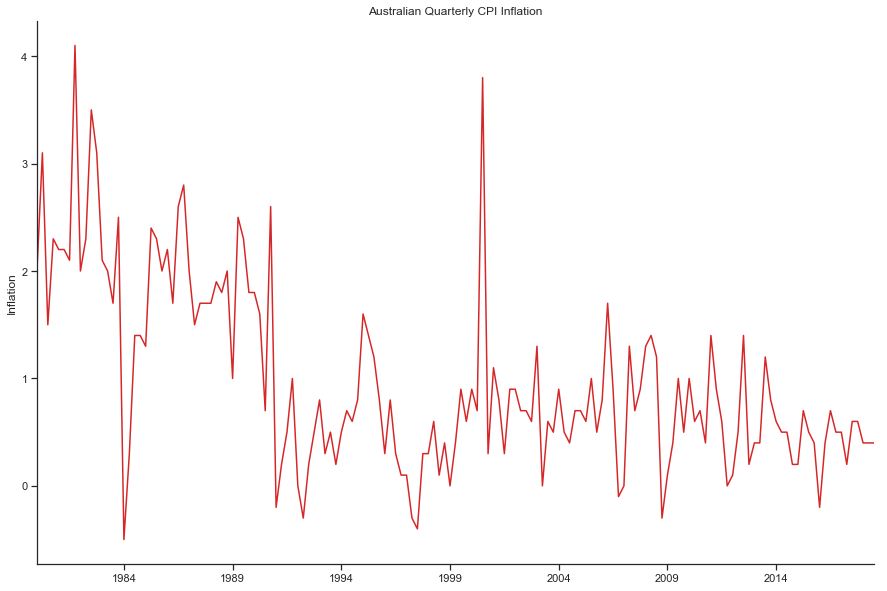

In [6]:
y=data['Inflation']

fig, ax= plt.subplots();#figsize=(9,6))
y.plot(color=red)
ax.set_xlabel('')
ax.set_ylabel('Inflation')
ax.set_title('Australian Quarterly CPI Inflation')
ax.set_xticks([], minor=True) # I prefer to remove the minor ticks for a cleaner plot
sns.despine()
plt.show()

## ARIMA model identification

The next cell plots the sample autocorrelations (ACF) and partial autocorrelations (PACF) for the entire series. The autocorrelations decay slowly, reflecting the non-stationarity of the series. 

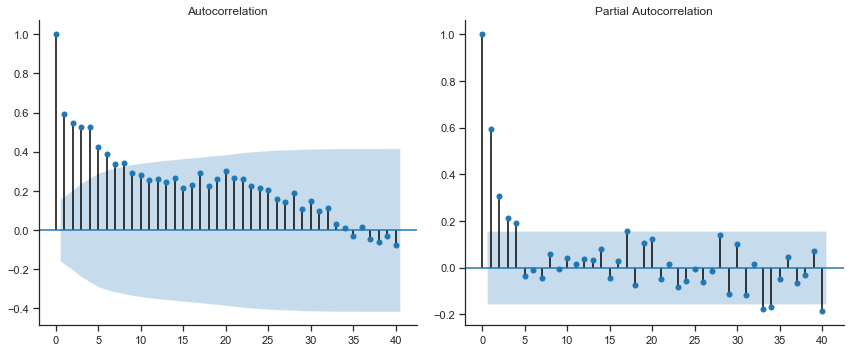

In [7]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
sm.graphics.tsa.plot_acf(y, lags=40, ax=ax[0])
sm.graphics.tsa.plot_pacf(y, lags=40, ax=ax[1])
sns.despine()
fig.tight_layout()
plt.show()

We then consider a first difference transform, which seems to lead to a stationary series for this data. The pandas [shift](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shift.html) method is the tool for obtaining lagged values of a column. 

The ACF plot for the first difference series has a cut-off after lag one, while the PACF shows a gradual decrease, suggesting a MA(1) for the data. 

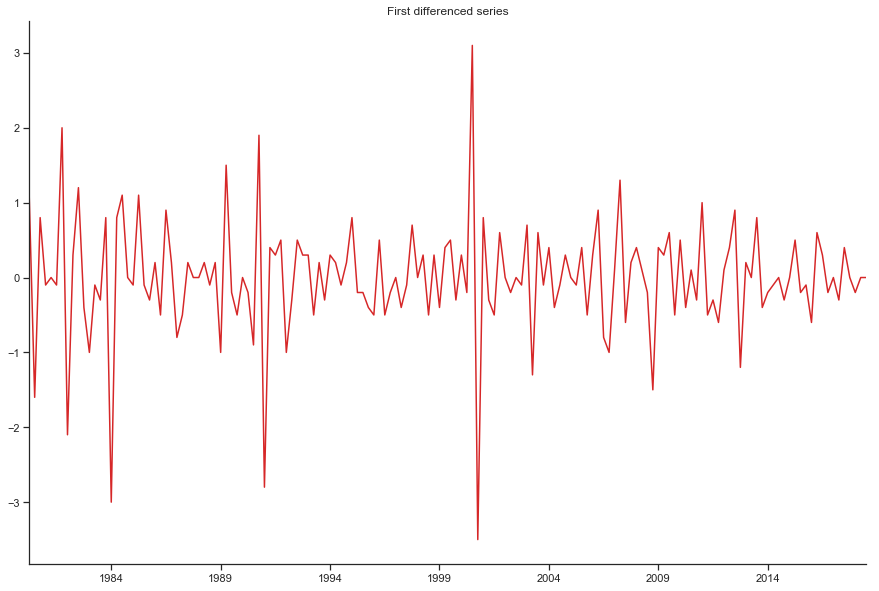

In [8]:
diff=y-y.shift(1)
diff=diff.dropna()

fig, ax= plt.subplots();#figsize=(9,6))
diff.plot(color=red)
ax.set_xlabel('')
ax.set_title('First differenced series')
ax.set_xticks([], minor=True) # I prefer to remove the minor ticks for a cleaner plot
sns.despine()
plt.show()

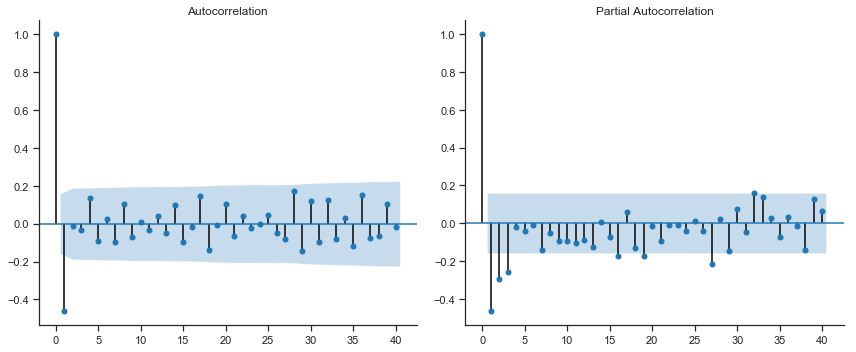

In [9]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
sm.graphics.tsa.plot_acf(diff, lags=40, ax=ax[0])
sm.graphics.tsa.plot_pacf(diff, lags=40, ax=ax[1])
sns.despine()
fig.tight_layout()
plt.show()

In the EDA, we saw that the series behaves differently in the post-2000 period, so that we can also consider focusing on this part of the dataset only. The need for first differencing is less clear in this case, so that we will consider specifications with and without the transformation

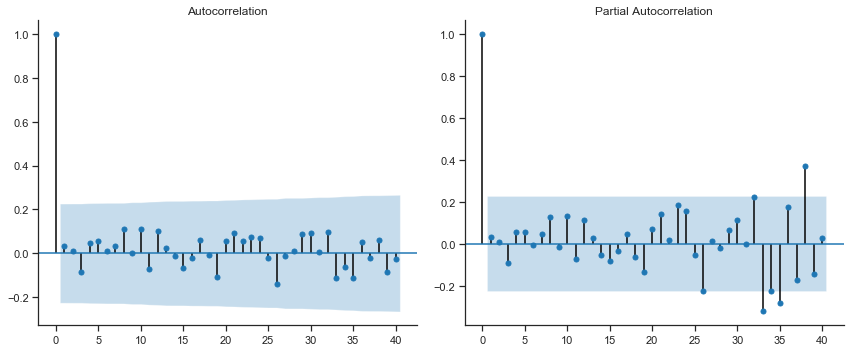

In [10]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
sm.graphics.tsa.plot_acf(y['2000':], lags=40, ax=ax[0])
sm.graphics.tsa.plot_pacf(y['2000':], lags=40, ax=ax[1])
sns.despine()
fig.tight_layout()
plt.show()

With the first difference, the ACF and PACF are again consistent with an MA(1) process. 

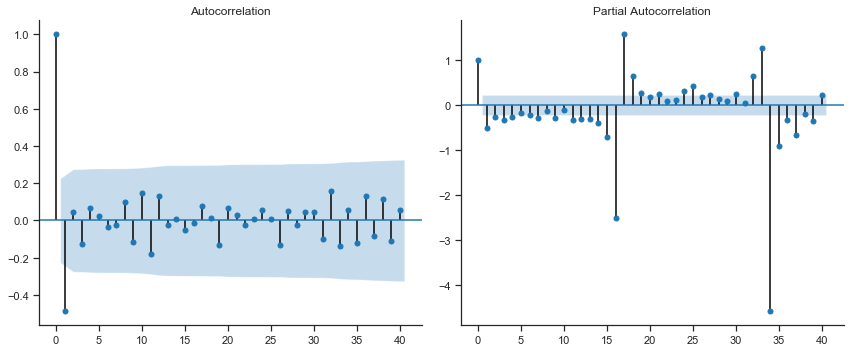

In [11]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
sm.graphics.tsa.plot_acf(diff['2000':], lags=40, ax=ax[0])
sm.graphics.tsa.plot_pacf(diff['2000':], lags=40, ax=ax[1])
sns.despine()
fig.tight_layout()
plt.show()

### Estimation

We now estimate the ARIMA(0,1,1) model for the full data using the <TT>statsmodels</TT> package.

In [12]:
arima1 = sm.tsa.ARIMA(y, order=(0, 1, 1)).fit(trend='nc') 
                        # trend='nc' option estimates a model without a drift
arima1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:            D.Inflation   No. Observations:                  154
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -150.667
Method:                       css-mle   S.D. of innovations              0.642
Date:                Fri, 13 Sep 2019   AIC                            305.334
Time:                        15:50:19   BIC                            311.408
Sample:                    06-30-1980   HQIC                           307.801
                         - 09-30-2018                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
ma.L1.D.Inflation    -0.7098      0.071    -10.027      0.000      -0.849      -0.571
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.4088           +0.0000j            1.4088            0.0000
-----------------------------------------------------------------------------
"""

Restricting attention to the data since 2000, we consider two specifications: ARIMA(1,0,1) and ARIMA(0,1,1). Note that for the ARIMA(1,0,1) estimation, I remove the first observation to make it comparable to the ARIMA(0,1,1) output (which loses the first observation due to first differencing). 

The AIC and BIC criteria select the ARIMA(0,1,1) specification. Using only the 2000-2018 period substantially changes the estimate of the MA(1) coefficient. 

In [13]:
arima2 = sm.tsa.ARIMA(y['2000':].iloc[1:], order=(1, 0, 1)).fit(trend='nc')
arima2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:              Inflation   No. Observations:                   74
Model:                     ARMA(1, 1)   Log Likelihood                 -61.033
Method:                       css-mle   S.D. of innovations              0.542
Date:                Fri, 13 Sep 2019   AIC                            128.067
Time:                        15:50:19   BIC                            134.979
Sample:                    06-30-2000   HQIC                           130.824
                         - 09-30-2018                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
ar.L1.Inflation     0.9987      0.002    422.469      0.000       0.994       1.003
ma.L1.Inflation    -0.9332      0.043    -21.544      0.000      -1.018      -0.848
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0013           +0.0000j            1.0013            0.0000
MA.1            1.0716           +0.0000j            1.0716            0.0000
-----------------------------------------------------------------------------
"""

In [14]:
arima3 = sm.tsa.ARIMA(y['2000':], order=(0, 1, 1)).fit(trend='nc')
arima3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:            D.Inflation   No. Observations:                   74
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 -60.272
Method:                       css-mle   S.D. of innovations              0.539
Date:                Fri, 13 Sep 2019   AIC                            124.543
Time:                        15:50:19   BIC                            129.151
Sample:                    06-30-2000   HQIC                           126.382
                         - 09-30-2018                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
ma.L1.D.Inflation    -0.9309      0.043    -21.625      0.000      -1.015      -0.846
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.0743           +0.0000j            1.0743            0.0000
-----------------------------------------------------------------------------
"""

### Model diagnostics

To obtain the residual series:

In [15]:
resid=arima3.resid

As diagnostics, we plot the residual series, the ACF and PACF plots, and the histogram of the residual data. We find no autocorrelation patterns in the residuals, confirming that the ARIMA(0,1,1) adequately captures the time series dependence in the series. The histogram shows that the residual series is non-Gaussian, so that we should not rely on this assumption for building forecast intervals. 

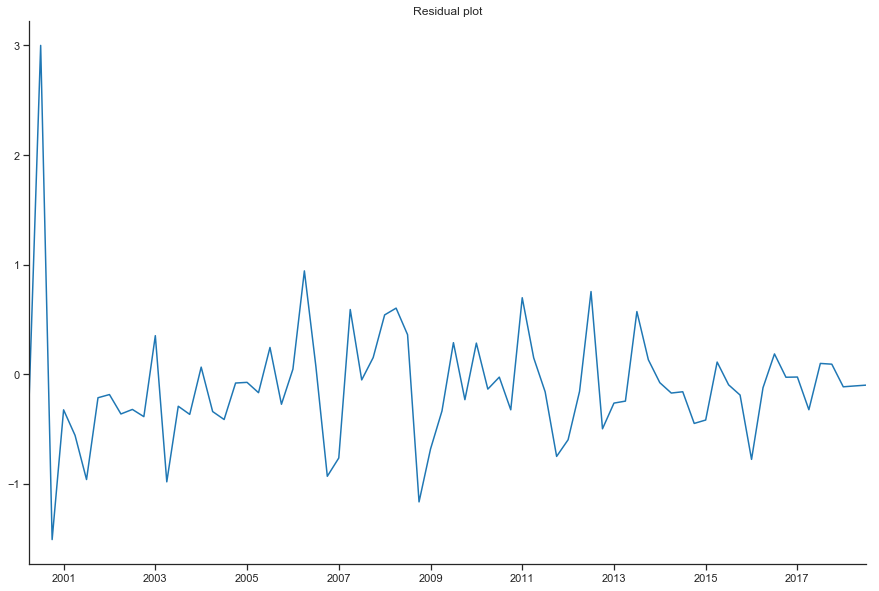

In [16]:
fig, ax= plt.subplots();#figsize=(9,6))
resid.plot(color=blue)
ax.set_xlabel('')
ax.set_xticks([], minor=True) 
ax.set_title('Residual plot')
sns.despine()
plt.show()

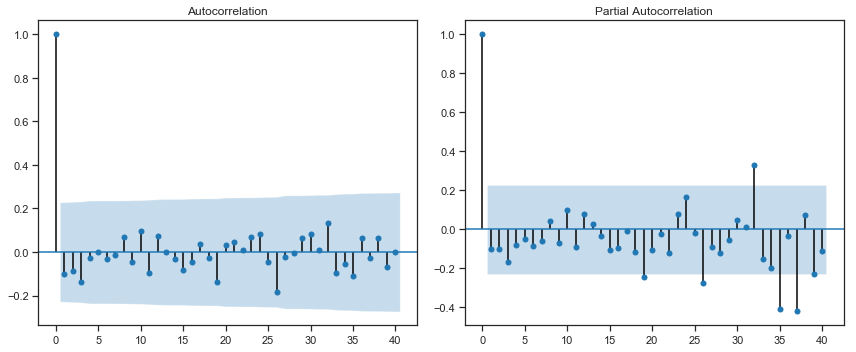

In [17]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
sm.graphics.tsa.plot_acf(resid, lags=40, ax=ax[0])
sm.graphics.tsa.plot_pacf(resid, lags=40, ax=ax[1])
plt.tight_layout()
plt.show()

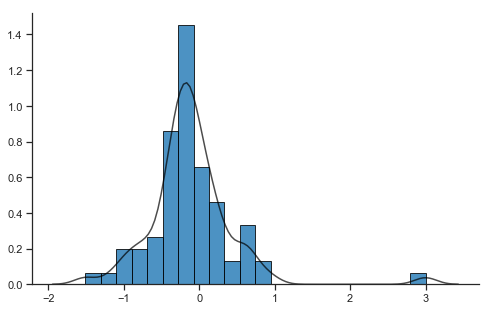

In [18]:
from plotting import histogram

histogram(resid)
plt.show()

## Model validation

We implement a real time forecasting exercise to select the best model for the final forecast. 

In [19]:
# Real time forecasting 

validation=y['2007Q1':].index # the validation period is Q1 2007 onwards
start = y.index.get_loc('2007Q1') # numerical index corresponding to Q1 2007
recent = y.index.get_loc('2000Q1')

results=pd.DataFrame(0.0, index=validation, columns=['RW', 'SES', 'Trend corrected', 
                                                               'ARIMA', 'ARIMA (2000-)','Actual'])
results['Actual'] = y.iloc[start:]

order=(0, 1, 1)

for i in range(start, len(y)):
    
    j=i-start
    
    # random walk forecast
    results.iloc[j,0]=y.iloc[i-1] 
    
    # simple exponential smoothing
    model = sm.tsa.SimpleExpSmoothing(y.iloc[:i]).fit() 
    results.iloc[j,1]= model.forecast(1)[0]
    
    # trend corrrected
    model = sm.tsa.Holt(y.iloc[:i]).fit()
    results.iloc[j,2]=model.forecast(1)[0] 
    
    # ARIMA 
    model = sm.tsa.ARIMA(y.iloc[:i], order=order).fit()  
    results.iloc[j,3]=model.forecast()[0][0]
    
    # ARIMA (recent sample)
    model = sm.tsa.ARIMA(y.iloc[recent:i], order=order).fit()  
    results.iloc[j,4]= model.forecast()[0][0]

In [20]:
from scipy import stats

table = pd.DataFrame(0.0, index=results.columns[:-1], columns=['RMSE','SEM'])
for i in range(5):
    table.iloc[i,0] = sm.tools.eval_measures.rmse(results.iloc[:,i], results.iloc[:,-1])
    table.iloc[i,1] = (results.iloc[:,i] - results.iloc[:,-1]).sem()
table.round(3)

,RMSE,SEM
RW,0.515,0.076
SES,0.440,0.065
Trend corrected,0.440,0.065
ARIMA,0.442,0.065
ARIMA (2000-),0.423,0.062


## Forecast

We compute the final forecast using the ARIMA(0,1,1) model estimated on the full sample. 

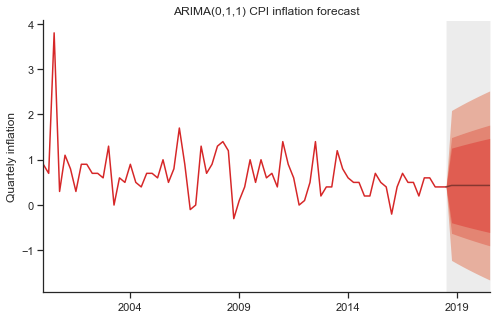

In [21]:
from plotting import fanchart

h=2*4 #Q 

pred, stderr, intv1 = arima1.forecast(steps=h, alpha=0.2)
pred, stderr, intv2 = arima1.forecast(steps=h, alpha=0.1)
pred, stderr, intv3 = arima1.forecast(steps=h, alpha=0.01)

test=pd.period_range(start=y.index[-1]+1, periods=h, freq='Q')

pred=pd.Series(pred, index=test)

intv1=pd.DataFrame(intv1, index=test)
intv2=pd.DataFrame(intv2, index=test)
intv3=pd.DataFrame(intv3, index=test)


fig, ax = fanchart(y['2000':], pred, intv1, intv2, intv3)
ax.set_xlabel('')
ax.set_xticks([], minor=True)
ax.set_ylabel('Quartely inflation')
sns.despine()
plt.title('ARIMA(0,1,1) CPI inflation forecast')

plt.show()